# Tutorial 3.2. Response of MDoF system 

### Description : Structural system may be idealised as a multi degree of freedom (MDoF) system for finding the responses under lateral wind loads. Static analysis, Eigen value analysis and dynamic analysis of MDoF is presented. Response of MDoF system under dynamic loads may be computed by different direct time integration schemes, which are presented here. Some exercises are proposed. 
#### The students are advised to complete the exercises. 

Project : Lecture - Structural Wind Engineering WS18-19 
        Chair of Structural Analysis @ TUM - R. Wüchner, M. Péntek
        
Author : kodakkal.anoop@tum.de mate.pentek@tum.de

Created on:  24.11.2016

Last update: 11.10.2018

##### Contents

1. Structural response of MDoF system under static and dynamic loads
2. Eigen Value analysis of MDoF system  
3. comparison of the performance of different Numerical integration schemes 

In [1]:
# import
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from matplotlib import animation, rc
from StructureMDoF import StructureMDoF

#### Creating the time instances as an array

The start time, end time and the number of time steps are specified here for generating the time series. 

In [2]:
# start time
startTime = 0.0
# end time
endTime = 10.0
# steps 
n = 10000
# time step
dt = endTime / (n-1)
# time instances
# generate grid size vectors 1D
arrayTime = np.arange(startTime, endTime+dt, dt)

### Modeling of the structure

#### The structure is modeled as MDoF system with masses lumped at floor levels. A translational degree of freedom is considered at each of the floor levels. 

![title](example111_akchopra)

The picture is adapted from from example 11.1 A.K. Chopra: Dynamics of Structures: Theory and Applications to Earthquake Engineering, Prentice-Hall, 1995

##### The mass matrix and stiffness matrix of a 3 DoF system looks like  

\begin{gather}
 K = \begin{bmatrix} 
 k_{1}+k_{2} & -k_{2} & 0 \\
 -k_{2} & k_{2}+k_{3} & -k_{3} \\
 0 & -k_{3} & k_{3} 
 \end{bmatrix}
\end{gather}
 


\begin{gather}
 M = \begin{bmatrix} 
 m_{1} & 0 & 0 \\
 0 & m_{2} & 0 \\
 0 & 0 & m_{3} 
 \end{bmatrix}
\end{gather}

where, $k_{1}$ and $m_{1}$ are the stiffness and mass at the first floor level respectively 


Interested readers may refer to __A.K. Chopra: Dynamics of Structures: Theory and Applications to
        Earthquake Engineering, Prentice-Hall, 1995__ for more details on dynamic analysis of structures

###### 3 DOF with given stiffness and mass matrix 

The mass and stiffness values of the 3 DoF are from example 11.1 A.K. Chopra: Dynamics of Structures: Theory and Applications to Earthquake Engineering, Prentice-Hall, 1995

In [3]:
# Stiffness matrix of the structure
K = 610 * np.array([[ 2, -1,  0],
                    [-1,  2, -1],
                    [ 0, -1,  1]])

# Mass matrix of the structure
M = 1/386 * np.array([[400, 0, 0],
                      [0, 400, 0],
                      [0, 0, 200]])

numberOfFloors = 3
levelHeight = 3.5
Z = np.zeros(numberOfFloors+1)
for i in range(numberOfFloors+1):
    Z[i] = levelHeight * i;

Z is the vector of height coordinates

###### For exercise 02 
A MDoF model of high rise building

In [4]:
## import or read-in -> sample data for a generic highrise
# import MDoFModelOfHighrise
# # stiffness matrix
# K = MDoFModelOfHighrise.stiffnessMatrix
# # mass matrix
# M = MDoFModelOfHighrise.massMatrix
# # height coordinates
# Z = MDoFModelOfHighrise.Z

### 3.1 Static Analysis

The response of the MDOF under a static load is computed.


###### Static load definition


Point load at the top 

In [5]:
staticForce = np.zeros(len(Z)-1)
staticForce[-1] = 1e2/2 #-50 [N]

###### For exercise 05 
The wind load for a wind velocity of 28.7 m/s at reference height of 10m is 

In [6]:
#velocityVector = 1.05 * 28.7 * pow(Z[1:]/10,0.2)
#staticForce = 0.5 * 2.0 * 1.2 * 600 * velocityVector**2

###### Solving for the static displacements 

In [7]:
staticDisp = np.linalg.solve(K,staticForce)

###### Computing the reaction at the bottom 

In [8]:
kBottom = K[0,0]/2
reactBottom = -kBottom * staticDisp[0] #-50 [N] 
print("Reaction at the bottom for static force: ", reactBottom, 'N')

Reaction at the bottom for static force:  -49.999999999999986 N


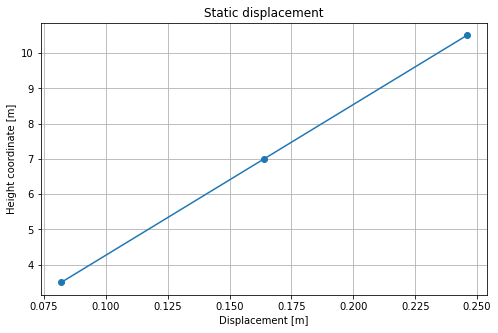

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(staticDisp,Z[1:],marker='o')
plt.title("Static displacement")
plt.xlabel("Displacement [m]")
plt.ylabel("Height coordinate [m]")
plt.grid(True)

### 3.2 Eigen Value Analysis

Eigen value analysis is conducted to identify the mode shapes and frequency of the MDOF. 
Computing the Eigen values, frequencies and periods of the MDOF

In [10]:
# Raw eigenvalues and eigenmodes
eigValsRaw,eigModesRaw = linalg.eig(K,M)

[nRow,mCol] = eigModesRaw.shape
eigModesNorm = np.zeros([nRow,mCol])

# Natural eigenvalues, eigenfrequencis and periods of the sturcture
eigVals = np.sqrt(np.real(eigValsRaw)) # in rad/sec
eigFreqs = eigVals/2/np.pi #in Hz
eigPer = 1./eigFreqs #in s


Normalizing the Modes. Refer to [slide 23](http://www.colorado.edu/engineering/CAS/courses.d/Structures.d/IAST.Lect19.d/IAST.Lect19.Slides.pdf) for normalization of eigen modes

The following checks are done for the normalization. 
1. Generalized mass should be identity
2. ThethaT dot M dot theta- numerically 0 for off-diagonal terms


In [11]:
genMassRaw = np.zeros(mCol)
genMassNorm = np.zeros(mCol)
print("Generalized mass should be identity")
for i in range(len(eigValsRaw)):
    genMassRaw[i] = (np.transpose(eigModesRaw[:,i])).dot(M).dot(eigModesRaw[:,i])
    unitGenMassNormFact = np.sqrt(genMassRaw[i])
    eigModesNorm[:,i] = eigModesRaw[:,i]/unitGenMassNormFact
    genMassNorm[i] = (np.transpose(eigModesNorm[:,i])).dot(M).dot(eigModesNorm[:,i])
    print("norm ",i,": ",genMassNorm[i])

print("Multiplication check: thethaT dot M dot theta: ",(np.transpose(eigModesNorm)).dot(M).dot(eigModesNorm)," numerically 0 for off-diagonal terms")

# modal masses and modal stiffnesses result in the squared natural frequencies
modalMass = np.zeros(mCol)
modalStifness = np.zeros(mCol)
checkEigVals = np.zeros(mCol)
for i in range(len(eigValsRaw)):
    modalMass[i] = (np.transpose(eigModesNorm[:,i])).dot(M).dot(eigModesNorm[:,i])
    modalStifness[i] = (np.transpose(eigModesNorm[:,i])).dot(K).dot(eigModesNorm[:,i])
    checkEigVals[i] = np.sqrt(modalStifness[i]/modalMass[i])


Generalized mass should be identity
norm  0 :  1.0
norm  1 :  1.0
norm  2 :  1.0
Multiplication check: thethaT dot M dot theta:  [[ 1.00000000e+00 -2.77555756e-16  2.77555756e-16]
 [-2.77555756e-16  1.00000000e+00 -4.99600361e-16]
 [ 2.77555756e-16 -4.99600361e-16  1.00000000e+00]]  numerically 0 for off-diagonal terms


Sorting the eigen modes

In [12]:
eigFreqSortedInd = np.argsort(eigFreqs)
# extend eigenmodes -> needed only for plotting, adding value for fixed/bottom node
extEigModes = np.zeros([nRow+1,mCol])
extEigModes [1:,:]=eigModesNorm

###### Let's Plot the first three eigen modes

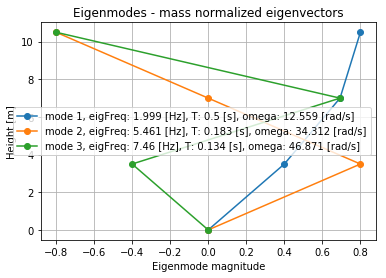

In [13]:
#plot eigenvalues and shapes
fig = plt.figure(2)

if mCol >= 3:
    mColToIterate = 3
else:
    mColToIterate = mCol
for i in range(mColToIterate):
    plt.plot(extEigModes[:,eigFreqSortedInd[i]],Z,marker='o',label="mode "+ str(i+1) + 
             ", eigFreq: " + str(np.round(eigFreqs[eigFreqSortedInd[i]],3)) + " [Hz], T: " + 
             str(np.round(eigPer[eigFreqSortedInd[i]],3)) +" [s], omega: " + 
             str(np.round(eigVals[eigFreqSortedInd[i]],3)) + " [rad/s]")

plt.title("Eigenmodes - mass normalized eigenvectors")
plt.xlabel("Eigenmode magnitude")
plt.ylabel("Height [m]")
plt.legend(loc='best')
plt.grid(True)


###### Let's look at the animation of the I th eigen mode

select the mode to be animated. 

In [14]:
modeIIndex = 1 # for naming modes - 1 to n

In [15]:
modeI = modeIIndex-1 # for python convection subtract 1
eigenformI = extEigModes[:,eigFreqSortedInd[modeI]]
omegaI = eigVals[eigFreqSortedInd[modeI]]
periodI = eigPer[eigFreqSortedInd[modeI]]
n = 1 #number of periods
simulTime =np.linspace(0,n*periodI,20*n)

#First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(8, 6))

ax = plt.axes(xlim=(-max(np.absolute(eigenformI))-1/10*max(np.absolute(eigenformI)), +max(np.absolute(eigenformI))+1/10*max(np.absolute(eigenformI))), ylim=(0, max(Z)+1.0))
#line, = ax.plot([], [], lw=2)
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
ax.set_xlabel("Nodal position Y [m]")
ax.set_ylabel("Nodal position Z [m]")
ax.set_title("Nodal displacement plot in time [t]")
ax.grid(True)

# Data Placeholders
xd=np.zeros(0)
t=np.zeros(0)

# set plots
lwf=2
displI, = ax.plot(t,xd,'b-h', label="mode "+ str(modeI+1) + ", eigFreq: " + str(np.round(eigFreqs[eigFreqSortedInd[modeI]],3)) + " [Hz], T: " + str(np.round(eigPer[eigFreqSortedInd[modeI]],3)) +" [s], omega: " + str(np.round(eigVals[eigFreqSortedInd[modeI]],3)) + " [rad/s]", lw = lwf)
ax.legend([displI], [displI.get_label()])

# animation function.  This is called sequentially
def animate(i):
    global x
    global yp
    global t

    # plot the time
    time = simulTime[i]
    time_text.set_text('time = %.2f' % time)

    displacementYI = eigenformI * np.sin(omegaI * time)

    displI.set_data(displacementYI, Z)
    
    return displI

# call the animator.  blit=True means only re-draw the parts that have changed.
# interval: draw new frame every 'interval' ms
anim = animation.FuncAnimation(fig, animate, blit=False, frames=len(simulTime), interval=100, repeat=True)
plt.close() # prevents inline display

In [16]:
# on windows
plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\ga39med\\Downloads\\ffmpeg-4.0.2-win64-static\\ffmpeg-4.0.2-win64-static\\bin\\ffmpeg.exe'
# on linux
# plt.rcParams['animation.ffmpeg_path'] = u'/home/username/anaconda/envs/env_name/bin/ffmpeg' 

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
anim

### 3.3 Dynamic Analysis

The response of MDOF under dynamic loading is computed by different time integration. Three time integration is presented in this section. 
1. __Generalised-Alpha__
2. __Euler First and Second Order__

_THE OBJECT-ORIENTED GENERALIZED-ALPHA SOLVER
Implementation adapted from I. Hanzlicek (2014). Original implementation by M. Andre described in: Formulation of the Generalized-Alpha method for LAGRANGE. Technical Report, Chair of Structural Analysis @TUM, 2012.
See J. Chung, G.M. Hulbert: A time integration algorithm for structural dynamics
wih improved numerical dissipation: the generalized-aplha mehod. ASME J. Appl. 
Mech., 60:371-375,1993._

_THE EULER ALGORITHM USING FIRST AND SECOND ORDER APPROXIMATION
Implementation of the well-known finite difference approach, theory also
described in J.L. Cieslinski, B. Ratkiewicz: On the Simulations of the Classical
Harmonic Oscillator Equations by Difference Equations, PY 502, Hindawi Publishing 
Corporation, Advances in Difference Equations, Volume 2006. An algorithmic description
can also be found in H.P. Gavin: Numerical Integration in Structural Dynamics,
CEE 541, Structural Dynamics, Department of Civil & Environmental Engineering, 
Duke University Fall 2016._

An undamped system is assumed in this example. Interested students may refer to the Version 1 and version 2 codes provided for detailed implementation of 
__Rayleigh damping, 
Cauchy damping, and 
Superposed damping__

In [17]:
# for no damping
B = np.zeros(K.shape)

######  Initial conditions

In [18]:

# for free vibration - starting from 1st eigenmode
vu0 = eigModesNorm[:,eigFreqSortedInd[0]]
vv0 = np.zeros(M.shape[0])
va0 = np.zeros(M.shape[0])

###### For exercise 01
For harmonic excitation use the following section

In [19]:
# # initial displacement vector - set to zero for zero initial displacement and forced vibration case 
# vu0 = np.zeros(M.shape[0])

######  Plot of Initial displacements

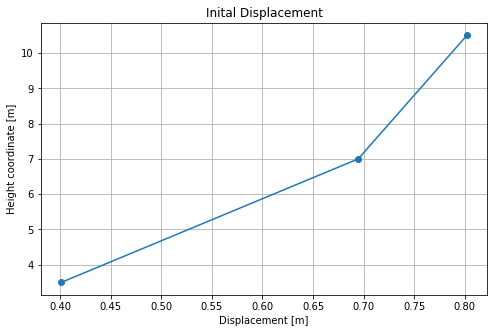

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(vu0,Z[1:],marker='o')
plt.title("Inital Displacement")
plt.xlabel("Displacement [m]")
plt.ylabel("Height coordinate [m]")
plt.grid(True)

###### External loading  

Two types of loads are defined here. 
1. Free vibration case - No external loads
2. Harmonic excitation

In [21]:

## for no external force
extForce = np.zeros((len(vu0),len(arrayTime)))


###### For exercise 01
For harmonic excitation use the following section

In [22]:

# # for harmonic excitation
# scalingFactor = 1.5
# # select mode to excite harmonically
# mode = 1
# i = mode -1
# for j in range(len(arrayTime)):
#     extForce[:,j] = eigModesNorm[:,eigFreqSortedInd[i]] * scalingFactor * np.sin(eigVals[eigFreqSortedInd[i]] * arrayTime[j])


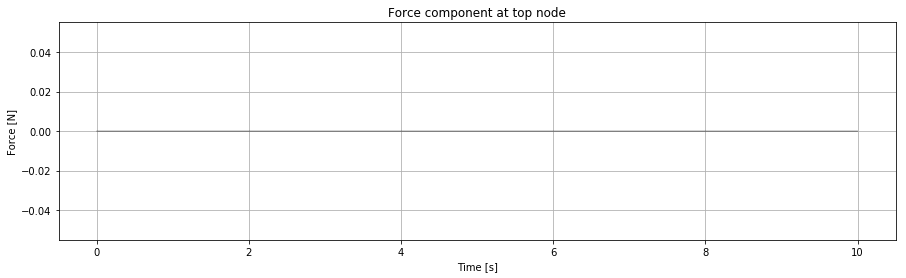

In [23]:
#plot for force - for top dof
plt.figure(figsize=(15, 4))
plt.plot(arrayTime, extForce[M.shape[0]-1,:], "-k", lw=0.5)
plt.ylabel('Force [N]')
plt.xlabel('Time [s]')
plt.title("Force component at top node")
plt.grid(True)

##### Time integration schemes 

Solving the equation of motion at each time step  

In [24]:
pInf = 0.15 # numerical parameter -> only needed for the GeneralizedAlpha solver
# create an object: structure - to be used by the GeneralizedAlpha scheme
structure = StructureMDoF(dt, M, B, K, pInf, vu0, vv0, va0)
#structure.printSetup()

##### Tip: Have a look at "StructureMDoF.py" for details 

In [25]:
## data for storing results

# using objects - dictionaries would also be a good option
# create a samplaData class
class sampleData(): pass

# initiate objects and labels
dataEuler12 = sampleData()
dataEuler12.label = "Euler 1st & 2nd"

dataGenAlpha = sampleData()
dataGenAlpha.label = "Gen Alpha"

# lists to store the results
dataEuler12.disp = []
dataEuler12.acc  = []
dataEuler12.vel  = []

dataGenAlpha.disp = []
dataGenAlpha.acc  = []
dataGenAlpha.vel  = []

# ===============================================================================
# computation time for each method
dataEuler12.computTime = 0.0
dataGenAlpha.computTime = 0.0

# initial values
dataEuler12.disp.append(vu0)
dataEuler12.vel.append(vv0)
dataEuler12.acc.append(va0)

dataGenAlpha.disp.append(vu0)
dataGenAlpha.vel.append(vv0)
dataGenAlpha.acc.append(va0)

# more initial values for the time integration schemes
dataEuler12.un2 = vu0
dataEuler12.un1 = vu0 - (vv0*dt) + (dt ** 2 / 2) * va0
dataEuler12.vn1 = vv0
dataEuler12.an1 = va0

###### Time loop : Computing the response at each time instant

In [26]:
## Computation loop
for i in range(1, len(arrayTime)):
    currentTime = arrayTime[i]

    # ===========================================================================
    ## Euler 1st and 2nd order
    t = time.time()

    # solve the time integration step
    # second order approximation of acceleration, first order for velocity
    # version 1 - eq. 5.3
    # LHS = M
    # RHS = extForce[i-1] * dt**2 + np.dot(dataEuler12.un1, (2*M - B * dt - K *dt**2)) + np.dot(dataEuler12.un2, (-M + B * dt))
    # version 2 - eq. 5.4 from J.L. Cieslinski, B. Ratkiewicz or eq. 6 from H.P. Gavin
    LHS = M + np.dot(B, dt / 2)
    RHS = extForce[:,i] * dt ** 2 + np.dot(dataEuler12.un1, (2 * M - K * dt ** 2)) + np.dot(dataEuler12.un2, (-M + B * dt / 2))

    # version 3 - eq. 5.5
    # LHS = M + B * dt
    # RHS = extForce[i-1] * dt**2 + np.dot(dataEuler12.un1, (2*M + B * dt - K *dt**2)) + np.dot(dataEuler12.un2, (-M))

    dataEuler12.un0 = np.linalg.solve(LHS, RHS)

    dataEuler12.vn0 = (dataEuler12.un0 - dataEuler12.un2) / 2 / dt
    dataEuler12.an0 = (dataEuler12.un0 - 2 * dataEuler12.un1 + dataEuler12.un2) / dt ** 2

    # append results to list
    dataEuler12.disp.append(dataEuler12.un0)
    dataEuler12.vel.append(dataEuler12.vn0)
    dataEuler12.acc.append(dataEuler12.an0)

    # update results
    dataEuler12.un2 = dataEuler12.un1
    dataEuler12.un1 = dataEuler12.un0

    # elapsed time accumulated
    dataEuler12.computTime += time.time() - t

    # ===========================================================================
    ## Generalized Alpha
    t = time.time()

    # solve the time integration step
    structure.solveStructure(extForce[:,i])

    # append results to list
    dataGenAlpha.disp.append(structure.getDisplacement())
    dataGenAlpha.vel.append(structure.getVelocity())
    dataGenAlpha.acc.append(structure.getAcceleration())

    # update results
    structure.updateStructureTimeStep()

    # elapsed time accumulated
    dataGenAlpha.computTime += time.time() - t

In [27]:
## Plot results
# Select Nodal DOF (fo this case equivalent to story height)
node = 3
dof = node-1
xAxisEnd = endTime

# 

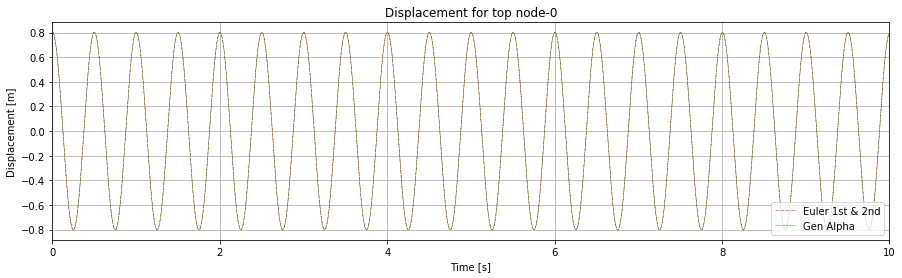

In [28]:
#plot for displacement - top dof
plt.figure(figsize=(15, 4))
plt.plot(arrayTime, [row[dof] for row in dataEuler12.disp], "-.r", label=dataEuler12.label, lw=0.5)
plt.plot(arrayTime, [row[dof] for row in dataGenAlpha.disp], "--g", label=dataGenAlpha.label, lw=0.5)
plt.xlim([0, xAxisEnd])
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title("Displacement for top node-0")
plt.legend(loc=4)
plt.grid(True)

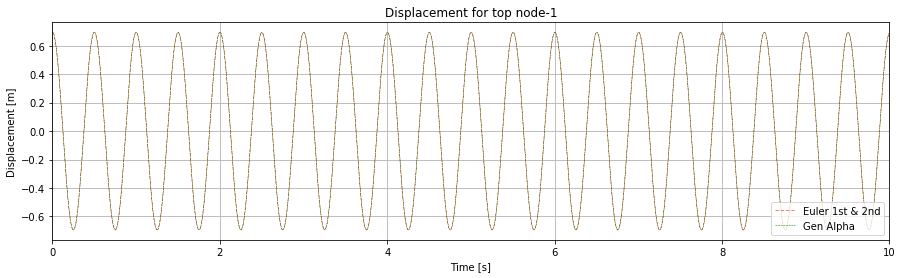

In [29]:
#plot for displacement - top dof
plt.figure(figsize=(15, 4))
plt.plot(arrayTime, [row[dof-1] for row in dataEuler12.disp], "-.r", label=dataEuler12.label, lw=0.5)
plt.plot(arrayTime, [row[dof-1] for row in dataGenAlpha.disp], "--g", label=dataGenAlpha.label, lw=0.5)
plt.xlim([0, xAxisEnd])
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title("Displacement for top node-1")
plt.legend(loc=4)
plt.grid(True)

### Exercise 01 : Dynamic analysis under harmonic loads

Apply a harmonic load excited in mode 1 with no initial displacement. Obsever the differance in responses 

### Exercise 02 : Dynamic analysis of MDoF model of a highrise

Import the MDOF model of the tower provided and compute the responses of the tower. 

### Exercise 03 : Modify the time step dt 

Modify the time step dt by changing the number of timesteps 'n' . Comment on the results 

### Exercise 04 : Modify Pinf

Modify the numerical parameter pInf and observe and comment on the result

 ## Check Point -  1 : Discussion

#### Discuss among groups the observations and outcomes from exercises

### Assignment: Apply Wind loads

Create and apply a static load case of the wind profile already determined, also apply a dynamic version of it. See the notes and exercises related to Bluff Body Aerodynamics.